
# Efficient patch generation

This notebook demonstrates how to efficiently generate fixed-duration
excerpts of a signal using `librosa.util.frame`.
This can be helpful in machine learning applications where a model may
expect inputs of a certain size during training, but your data may be
of arbitrary and variable length.

Aside from being a convenient helper method for patch sampling, the
`librosa.util.frame` function can do this *efficiently* by avoiding
memory copies.
The patch array produced below is a *view* of the original data array,
not a copy.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import librosa
from IPython.display import Audio

Load an example clip



In [2]:
y, sr = librosa.load(librosa.ex('libri1'))

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [9]:

Audio(data=y, rate=sr)

Compute a log-scaled Mel spectrogram



In [10]:
melspec = librosa.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr),
                              ref=np.max)

The resulting spectrogram has a number of frames
that depends on the length of the input signal `y`:



In [11]:
print(f"Mel spectrogram shape: {melspec.shape}")

Mel spectrogram shape: (128, 640)


[Text(0.5, 1.0, 'Full Mel spectrogram')]

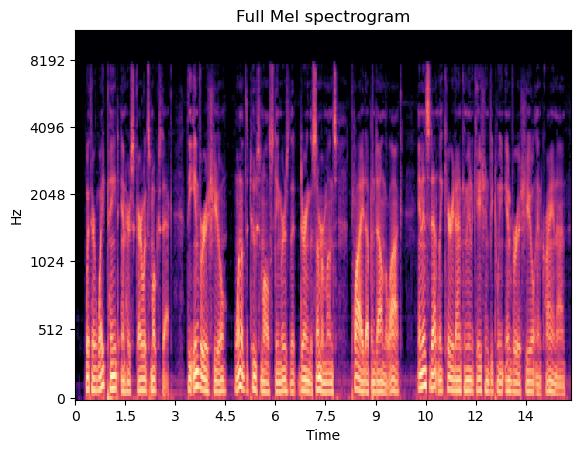

In [12]:
fig, ax = plt.subplots()
librosa.display.specshow(melspec, x_axis='time', y_axis='mel', ax=ax)
ax.set(title='Full Mel spectrogram')

We can use librosa.util.frame to carve
`melspec` into patches of fixed duration.

In this case, we'll make ~5-second patches
separated by approximately 1/10 second each.



In [13]:
frame_length = librosa.time_to_frames(5.0)
hop_length = librosa.time_to_frames(0.10)
print(f"Frame length={frame_length}, hop length={hop_length}")

Frame length=215, hop length=4


In [14]:
patches = librosa.util.frame(melspec,
                             frame_length=frame_length,
                             hop_length=hop_length)

The resulting `patches` array is now three-dimensional,
with axes corresponding to [frequency, time, patch index]



In [15]:
print(f"Patch array shape: {patches.shape}")

Patch array shape: (128, 215, 107)


So ``patches[..., 0]`` is the first 1-second patch,
``patches[..., 1]`` is the second 1-second patch,
and so on.  All patches will have the same shape.

Unlike the framing operation used by spectrogram functions,
these patches are **not** centered; they are left-aligned.
This means that the first patch, ``patches[..., 0]``
corresponds to the original data ``melspec[..., 0:frame_length]``.
The second patch ``patches[..., 1]`` corresponds to data
``melspec[..., hop_length:hop_length+frame_length]``,
the third patch ``patches[..., 2]`` corresponds to
``melspec[..., 2*hop_length:2*hop_length+frame_length]``, etc.

The figure below illustrates the first three patches.
Because the overlap (1/10) is small relative to the patch length (5),
these patches have substantial overlap and contain mostly the same
content but at different time offsets.



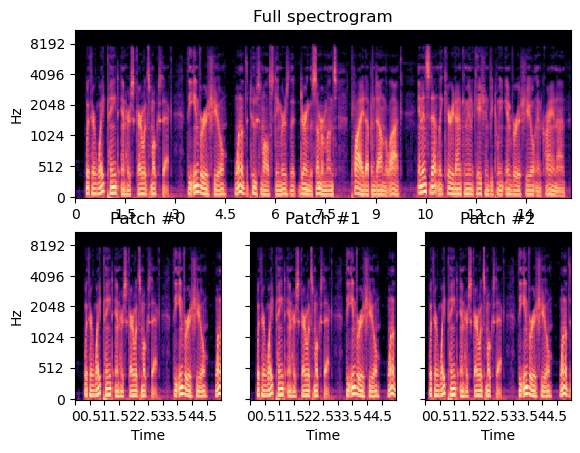

In [18]:
fig, ax = plt.subplot_mosaic([list("AAA"), list("012")])

librosa.display.specshow(melspec, x_axis='time', y_axis='mel', ax=ax["A"])
ax["A"].set(title='Full spectrogram', xlabel=None)

for index in [0, 1, 2]:
    librosa.display.specshow(patches[..., index],
                             x_axis='time', y_axis='mel',
                             ax=ax[str(index)])
    ax[str(index)].set(title=f"Patch #{index}")
    ax[str(index)].label_outer()

The animation below illustrates each patch in approximate
real time.



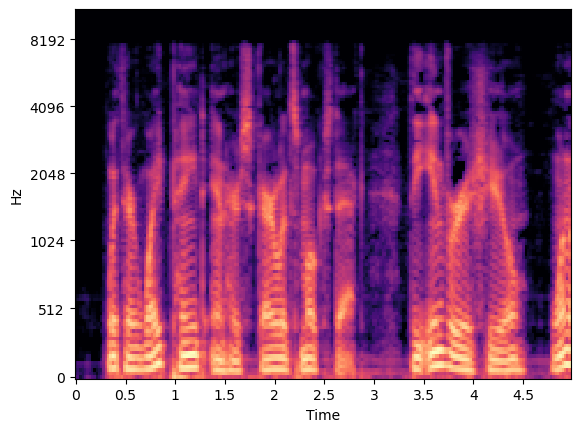

In [19]:
# We'll plot the first patch to create the display object,
# then animate the rest.

# sphinx_gallery_thumbnail_number = 2

fig, ax = plt.subplots()
mesh = librosa.display.specshow(patches[..., 0], x_axis='time',
                                y_axis='mel', ax=ax)


# This helper function is used to render each frame of the animation
# Updating the mesh object is much more efficient than rendering an
# entirely new spectrogram for each frame!
#
# Note that the "time" axis of this figure corresponds to the time
# within the patch; not the absolute time in the original signal.
#
def _update(num):
    mesh.set_array(patches[..., num])
    return (mesh,)


ani = animation.FuncAnimation(fig,
                              func=_update,
                              frames=patches.shape[-1],
                              interval=100,  # 100 milliseconds = 1/10 sec
                              blit=True)

In [25]:
len(patches[..., 0])

128

In [24]:
patches[..., 0].shape

(128, 215)

In [26]:
y_p = librosa.istft(patches[..., 0], length=len(patches[..., 0]))
Audio(data=y_p, rate=sr)